# WITBook

This notebook demonstrates the method for reproducing results from the Wetlands Insight Tool.

## Setup

Import packages:

In [1]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
from dea_tools.spatial import xr_rasterize
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Connect to the datacube:

In [2]:
dc = datacube.Datacube(app='witbook')

## Data loading

Load a shapefile with the polygon of interest:

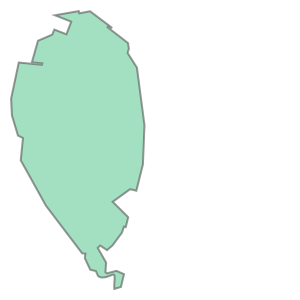

In [3]:
poly = gpd.read_file('hird/hird.shp')
poly.geometry[0]

...and specify a time period to examine:

In [4]:
time = ('1995-01-01', '2000-01-01')

Then load Landsat, Water Observations, and Fractional Cover:

In [5]:
bands = [f'nbart_{band}' for band in ('blue', 'green', 'red', 'nir', 'swir_1', 'swir_2')]

In [6]:
gpgon = datacube.utils.geometry.Geometry(poly.geometry[0], crs=poly.crs)

In [7]:
ds = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3', 'ga_ls7e_ard_3', 'ga_ls5t_ard_3'], ls7_slc_off=False, measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     time=time, group_by='solar_day')

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying pixel quality/cloud mask
Loading 189 time steps


In [8]:
ds_wo = dc.load('ga_ls_wo_3', resampling='nearest', group_by='solar_day', like=ds)
ds_fc = dc.load('ga_ls_fc_3', resampling='nearest', group_by='solar_day', like=ds)

Find any missing observations:

In [9]:
missing = set()
for t1, t2 in itertools.product(
        [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2):
    missing_ = set(t1) - set(t2)
    missing |= missing_

...and delete them:

In [10]:
ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])

Finally, calculate Tasseled-Cap Wetness:

In [11]:
tcw = dea_tools.bandindices.calculate_indices(
    ds, index='TCW', collection='ga_ls_3',
    normalise=False, drop=True, inplace=False)

Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


## WIT calculation

For each pixel, we calculate its WIT values based on the Flowchart from Dunn et al. (in prep).

Divide out the FC values by 100 to keep them in $[0, 1]$ (ignoring for now that values can exceed 100 due to how FC is calculated):

In [12]:
bs = ds_fc.bs / 100
pv = ds_fc.pv / 100
npv = ds_fc.npv / 100

Generate the WIT raster bands:

In [13]:
rast_names = ['pv', 'npv', 'bs', 'wet', 'water']
output_rast = {n: xr.zeros_like(bs) for n in rast_names}

output_rast['bs'].values[:] = bs
output_rast['pv'].values[:] = pv
output_rast['npv'].values[:] = npv

Mask cloudy/cloud shadowy/noncontiguous/no-data pixels and pixels not in the polygon:

In [14]:
poly_raster = xr_rasterize(poly, bs) > 0

# refs to: https://github.com/GeoscienceAustralia/dea-conflux/blob/main/examples/wit_ls5.conflux.py#L66

###
# https://github.com/GeoscienceAustralia/wofs/blob/3eacdc8b5b5c399fbe780cb9289e71b7d6ded31c/wofs/constants.py

#                    0           no water present
#     1              1<<0        nodata (missing all earth observation bands)
#     2              1<<1        noncontiguous (at least one EO band is missing or saturated)
#     4              1<<2        low solar incidence angle
#     8              1<<3        terrain shadow
#     16             1<<4        high slope
#     32             1<<5        cloud shadow
#     64             1<<6        cloud
#     128            1<<7        classified as water by the decision tree

#  0b0110011
# 0b01100011
###

#mask = (ds_wo.water & 0b0110011) == 0
mask = (ds_wo.water & 0b01100011) == 0
mask &= poly_raster

open_water = ds_wo.water & (1 << 7) > 0

wet = tcw.where(mask).TCW > -350

In [15]:
# TCW
output_rast['wet'].values[:] = wet.values.astype(float)
for name in rast_names[:3]:
    output_rast[name].values[wet.values] = 0

In [16]:
# WO
output_rast['water'].values[:] = open_water.values.astype(float)
for name in rast_names[:4]:
    output_rast[name].values[open_water.values] = 0

In [17]:
ds_wit = xr.Dataset(output_rast).where(mask)

Mask entire observations where the polygon is more than 10% masked:

In [18]:
pc_missing = (~mask).where(poly_raster).mean(dim=['x', 'y'])

# dea-conflux stop here

In [19]:
ds_wit = ds_wit.where(pc_missing < 0.1)

The WIT results are now computed. All that's left is to normalise them.

## Normalise WIT result example

In [20]:
# Assume vegetation relative values are:

water = 0.1
wet = 0.8

pv = 0.05
npv = 0.04
bs = 0.02

vegetation_area = 1 - water - wet

vegetation_overall_value = pv + npv + bs

print(f"The pv is {pv} \nThe npv is {npv} \nThe bs is {bs} \nThe overall number is {water + wet + pv + npv + bs}")

The pv is 0.05 
The npv is 0.04 
The bs is 0.02 
The overall number is 1.01


In [21]:
pv = pv/vegetation_overall_value*vegetation_area
npv = npv/vegetation_overall_value*vegetation_area
bs = bs/vegetation_overall_value*vegetation_area

In [22]:
print(f"The normalised pv is {pv} \nThe normalised npv is {npv} \nThe normalised bs is {bs} \nThe normalised overall number is {water + wet + pv + npv + bs}")

The normalised pv is 0.04545454545454545 
The normalised npv is 0.036363636363636355 
The normalised bs is 0.018181818181818177 
The normalised overall number is 1.0


In [23]:
def normalise_wit(ds_wit):
    
    import pandas as pd
    
    bands = ['water', 'wet', 'pv', 'npv', 'bs']
    
    polygon_base_df = pd.DataFrame()
    
    # covert ds_wit: XArray.Dataset to polygon_base_df: pandas.DataFrame
    # Then we can reuse the following codes in dea-conflux stack step
    polygon_base_df['date'] = ds_wit.time.values
    for band in bands:
        polygon_base_df[band] = ds_wit[band].mean(dim=['x', 'y'])
    
    # 1. compute the expected vegetation area total size: 1 - water (%) - wet (%)    
    veg_areas = 1 - polygon_base_df['water'] - polygon_base_df['wet']
    
    # 2. normalse the vegetation values based on vegetation size (to handle FC values more than 100 issue)
    # WARNNING: Not touch the water and wet, cause they are pixel classification result
    overall_veg_num = polygon_base_df['pv'] + polygon_base_df['npv'] + polygon_base_df['bs']

    for band in ['pv', 'npv', 'bs']:
        # archive the old values to debug
        polygon_base_df['original_' + band] = polygon_base_df[band]
        polygon_base_df[band] = (polygon_base_df[band]/overall_veg_num)*veg_areas
        
    polygon_base_df['original_total'] = polygon_base_df['water'] + polygon_base_df['wet'] + polygon_base_df['original_pv'] + polygon_base_df['original_npv'] + polygon_base_df['original_bs']
    polygon_base_df['total'] = polygon_base_df['water'] + polygon_base_df['wet'] + polygon_base_df['pv'] + polygon_base_df['npv'] + polygon_base_df['bs']
    
    return polygon_base_df

In [24]:
normalise_wit(ds_wit)

,date,water,wet,pv,npv,bs,original_pv,original_npv,original_bs,original_total,total
0,1995-01-07 23:28:16.440537,0.0,0.000000,0.310895,0.505365,0.183740,0.306836,0.498768,0.181342,0.986945,1.0
1,1995-01-16 23:21:45.780445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-02-01 23:21:07.993264,0.0,0.000000,0.302154,0.562371,0.135475,0.298289,0.555177,0.133742,0.987208,1.0
3,1995-02-08 23:27:01.295574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-02-17 23:20:28.160764,0.0,0.000415,0.312173,0.545001,0.142411,0.308229,0.538114,0.140612,0.987370,1.0
...,...,...,...,...,...,...,...,...,...,...,...
183,1999-12-06 00:02:06.760737,0.0,0.000000,0.298550,0.484580,0.216870,0.294555,0.478096,0.213968,0.986619,1.0
184,1999-12-13 23:44:22.751168,0.0,0.000000,0.287737,0.496084,0.216179,0.283881,0.489436,0.213281,0.986598,1.0
185,1999-12-20 23:50:31.137682,0.0,0.000000,0.245527,0.522300,0.232173,0.242904,0.516721,0.229693,0.989318,1.0
186,1999-12-29 00:08:11.123503,0.0,0.000415,0.278707,0.536477,0.184401,0.275140,0.529610,0.182041,0.987206,1.0


## Aspatial display

In [25]:
def display_wit_stack_with_df(polygon_base_df):
    pal = ['#030aa7',
           '#04d9ff',
           '#3f9b0b',
           '#e6daa6',
           '#60460f']
    
    # ingnore the null bs
    polygon_base_df = polygon_base_df.dropna(subset=['bs'])
    
    xs = polygon_base_df['date']

    plt.stackplot(xs, polygon_base_df["water"], polygon_base_df["wet"], polygon_base_df["pv"], polygon_base_df["npv"], polygon_base_df["bs"],
                  colors=pal, alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Fraction')
    plt.xlim(xs.min(), xs.max())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

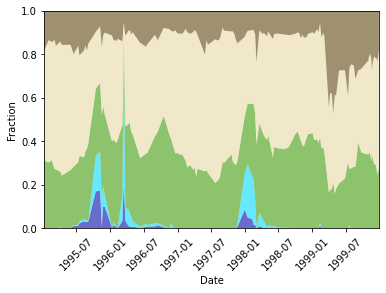

In [26]:
polygon_base_df = normalise_wit(ds_wit)
display_wit_stack_with_df(polygon_base_df)